In [23]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_filtered_scores_TORCHVISION, train_model
from NN import NN
from CNN import CNN
import similarities 
import DShap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),
      transforms.Resize((16,16))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

valid_dataset = torchvision.datasets.USPS(root='./data', train=True,
                                       download=True, transform=transform)

test_dataset = torchvision.datasets.USPS(root='./data', train=False,
                                       download=True, transform=transform)                        

In [38]:
test_dataset = torchvision.datasets.USPS(root='./data', train=False,
                                       download=True, transform=transform)     

In [21]:
model = CNN(in_conv=1, out_conv=24, out_channels=10, kernel_size=5, hidden_channels=200, norm=True, dropout=0.2, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=1))
dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)
dvgs.pretrain_(crit=torch.nn.CrossEntropyLoss(), num_workers=5, batch_size=256, lr=1e-3, epochs=10, use_cuda=True, verbose=True, report_metric=lambda x,y: accuracy_score(x,y.argmax(axis=1)))
#dvgs.model.freeze_conv_layer()
dvgs.model.fc.reset_parameters()
print()

tic = time.time() 
vals_dvgs, grad_mag = dvgs.run(crit          = torch.nn.CrossEntropyLoss(), 
                                similarity     = similarities.cosine_similarity(), 
                                optim          = torch.optim.Adam, 
                                lr             = 1e-3, 
                                num_epochs     = 100, 
                                compute_every  = 1, 
                                batch_size     = 2000, 
                                num_workers    = 1, 
                                grad_params    = ["fc.f.0.weight","fc.f.0.bias","fc.f.3.weight","fc.f.3.bias","fc.f.4.weight","fc.f.4.bias"], 
                                verbose        = True, 
                                use_cuda       = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

using device: cuda


/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch: 9 | loss: 1.4696 | metric: 1.0000
using device: cuda
epoch 99 || avg loss: 1.46 || grad time elapsed: 9.4 s] (0.0190s/batch)
time elapsed: 63.38 min


In [35]:
dvgs_data_values = vals_dvgs.mean(axis=1)

model = CNN(in_conv=1, out_conv=24, out_channels=10, kernel_size=5, hidden_channels=200, norm=True, dropout=0.2, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=1))
crit = torch.nn.CrossEntropyLoss() 
metric = lambda y,yhat: accuracy_score(y.ravel(), yhat.argmax(axis=1).ravel()) 

qs = np.linspace(0., 0.5, 5)
bs = 256 
nw = 1 
lr = 1e-3 
ep = 20
rp = 1

dvgs_low = get_filtered_scores_TORCHVISION(dvgs_data_values, copy.deepcopy(model), crit, metric, train_dataset, valid_dataset, qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)


/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


training filtered models... progress: 4/5


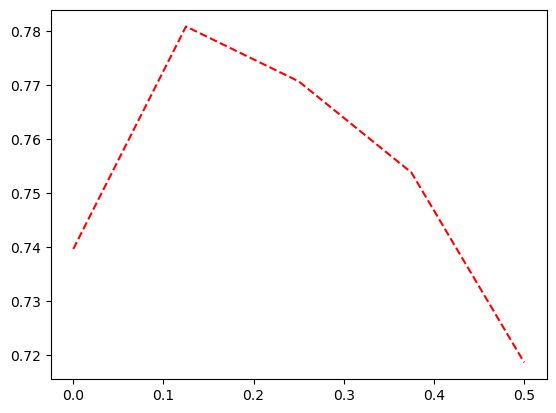

In [36]:
plt.figure()
plt.plot(qs, dvgs_low, 'r--')
plt.xlabel('Fraction training data removed')
plt.ylabel('Validation Performance (Accuracy)')
plt.title('Removing low data-values')
plt.show()

In [43]:
model = CNN(in_conv=1, out_conv=24, out_channels=10, kernel_size=5, hidden_channels=200, norm=True, dropout=0.2, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=1))


q = 0.2

low_t = np.quantile(dvgs_data_values, q)

print('low t:', low_t)

remove_low_idx = (dvgs_data_values >= low_t).nonzero()[0] 

print('train size:', len(remove_low_idx))

_train_dataset = copy.deepcopy(train_dataset)
_train_dataset.data[remove_low_idx,:,:]
_train_dataset.targets[remove_low_idx]

_, remove_low_res = train_model(model           = copy.deepcopy(model),
                                    crit            = crit, 
                                    metric          = metric,
                                    train_dataset   = _train_dataset, 
                                    test_dataset    = test_dataset, 
                                    batch_size      = bs,
                                    num_workers     = nw, 
                                    lr              = lr,
                                    epochs          = ep)
                            
_, baseline_res = train_model(model           = copy.deepcopy(model),
                                    crit            = crit, 
                                    metric          = metric,
                                    train_dataset   = train_dataset, 
                                    test_dataset    = test_dataset, 
                                    batch_size      = bs,
                                    num_workers     = nw, 
                                    lr              = lr,
                                    epochs          = ep)

print('MNIST->USPS Domain Adaptation:')
print('\tBaseline (no adaption):', baseline_res)
print('\tDVGS adaption:', remove_low_res)

low t: 0.003607443626970055
train size: 48000


/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MNIST->USPS Domain Adaptation:
	Baseline (no adaption): 0.7279521674140508
	DVGS adaption: 0.7433981066268062
